## Import modules


In [ ]:
from spezi_data_pipeline.data_access.firebase_fhir_data_access import FirebaseFHIRAccess
from spezi_data_pipeline.data_flattening.fhir_resources_flattener import flatten_fhir_resources, FHIRDataFrame
from spezi_data_pipeline.data_processing.data_processor import FHIRDataProcessor
from spezi_data_pipeline.data_processing.observation_processor import calculate_activity_index
from spezi_data_pipeline.data_exploration.data_explorer import DataExplorer, visualizer_factory, explore_total_records_number
from spezi_data_pipeline.data_export.data_exporter import DataExporter

## Define credential files

In [ ]:
# Define your Firebase project ID
project_id = "spezi-data-pipeline"  # Replace with your Firebase project ID

# Define the service account key file
service_account_key_file = "path_to_service_account_key_file.json"  # Replace with your service account key file

# Define the collection name where your FHIR observations are stored and the input code if filtering is needed
collection_name = "users"
subcollection_name = "HealthKit"

# Define the list of HealthKit quantities to query from Firebase Firestore
loinc_codes = ["55423-8"]

## Initialize the FirebaseFHIRAccess class using your Firebase credentials

In [ ]:
# Initialize the FirebaseFHIRAccess class using your Firebase credentials
firebase_access = FirebaseFHIRAccess(project_id, service_account_key_file)
firebase_access.connect()

fhir_observations = firebase_access.fetch_data(collection_name, subcollection_name, loinc_codes)

flattened_fhir_dataframe = flatten_fhir_resources(fhir_observations)

In [ ]:
flattened_fhir_dataframe.df.head()

## Explore the number of recordings in the database by LOINC code  

<Figure size 4000x5000 with 0 Axes>

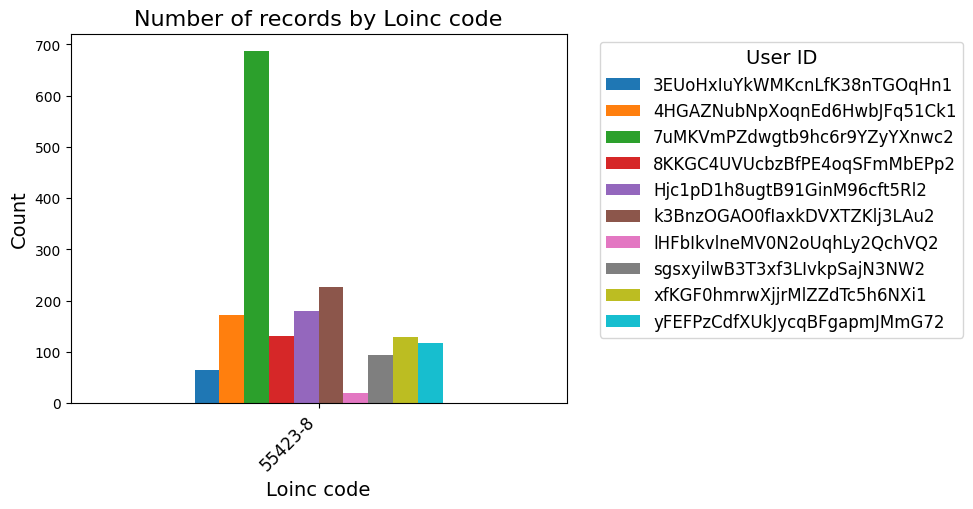

In [60]:
explore_total_records_number(flattened_fhir_dataframe.df)

## Apply basic processing for convenient data readability

In [ ]:
processed_fhir_dataframe = FHIRDataProcessor().process_fhir_data(flattened_fhir_dataframe)
processed_fhir_dataframe.df.head()

## Explore Data

### HealthKit Quantity Example

In [ ]:
selected_users = ["3EUoHxIuYkWMKcnLfK38nTGOqHn1","7uMKVmPZdwgtb9hc6r9YZyYXnwc2", "sgsxyilwB3T3xf3LIvkpSajN3NW2"]
selected_start_date = "2024-02-22"
selected_end_date = "2024-04-02"
explorer = visualizer_factory(processed_fhir_dataframe)

# explorer.set_user_ids(selected_users)
# explorer.set_date_range(selected_start_date, selected_end_date)
# explorer.set_y_bounds(50, 50000)

figs = explorer.create_static_plot(processed_fhir_dataframe)

### Calculate Activity Index

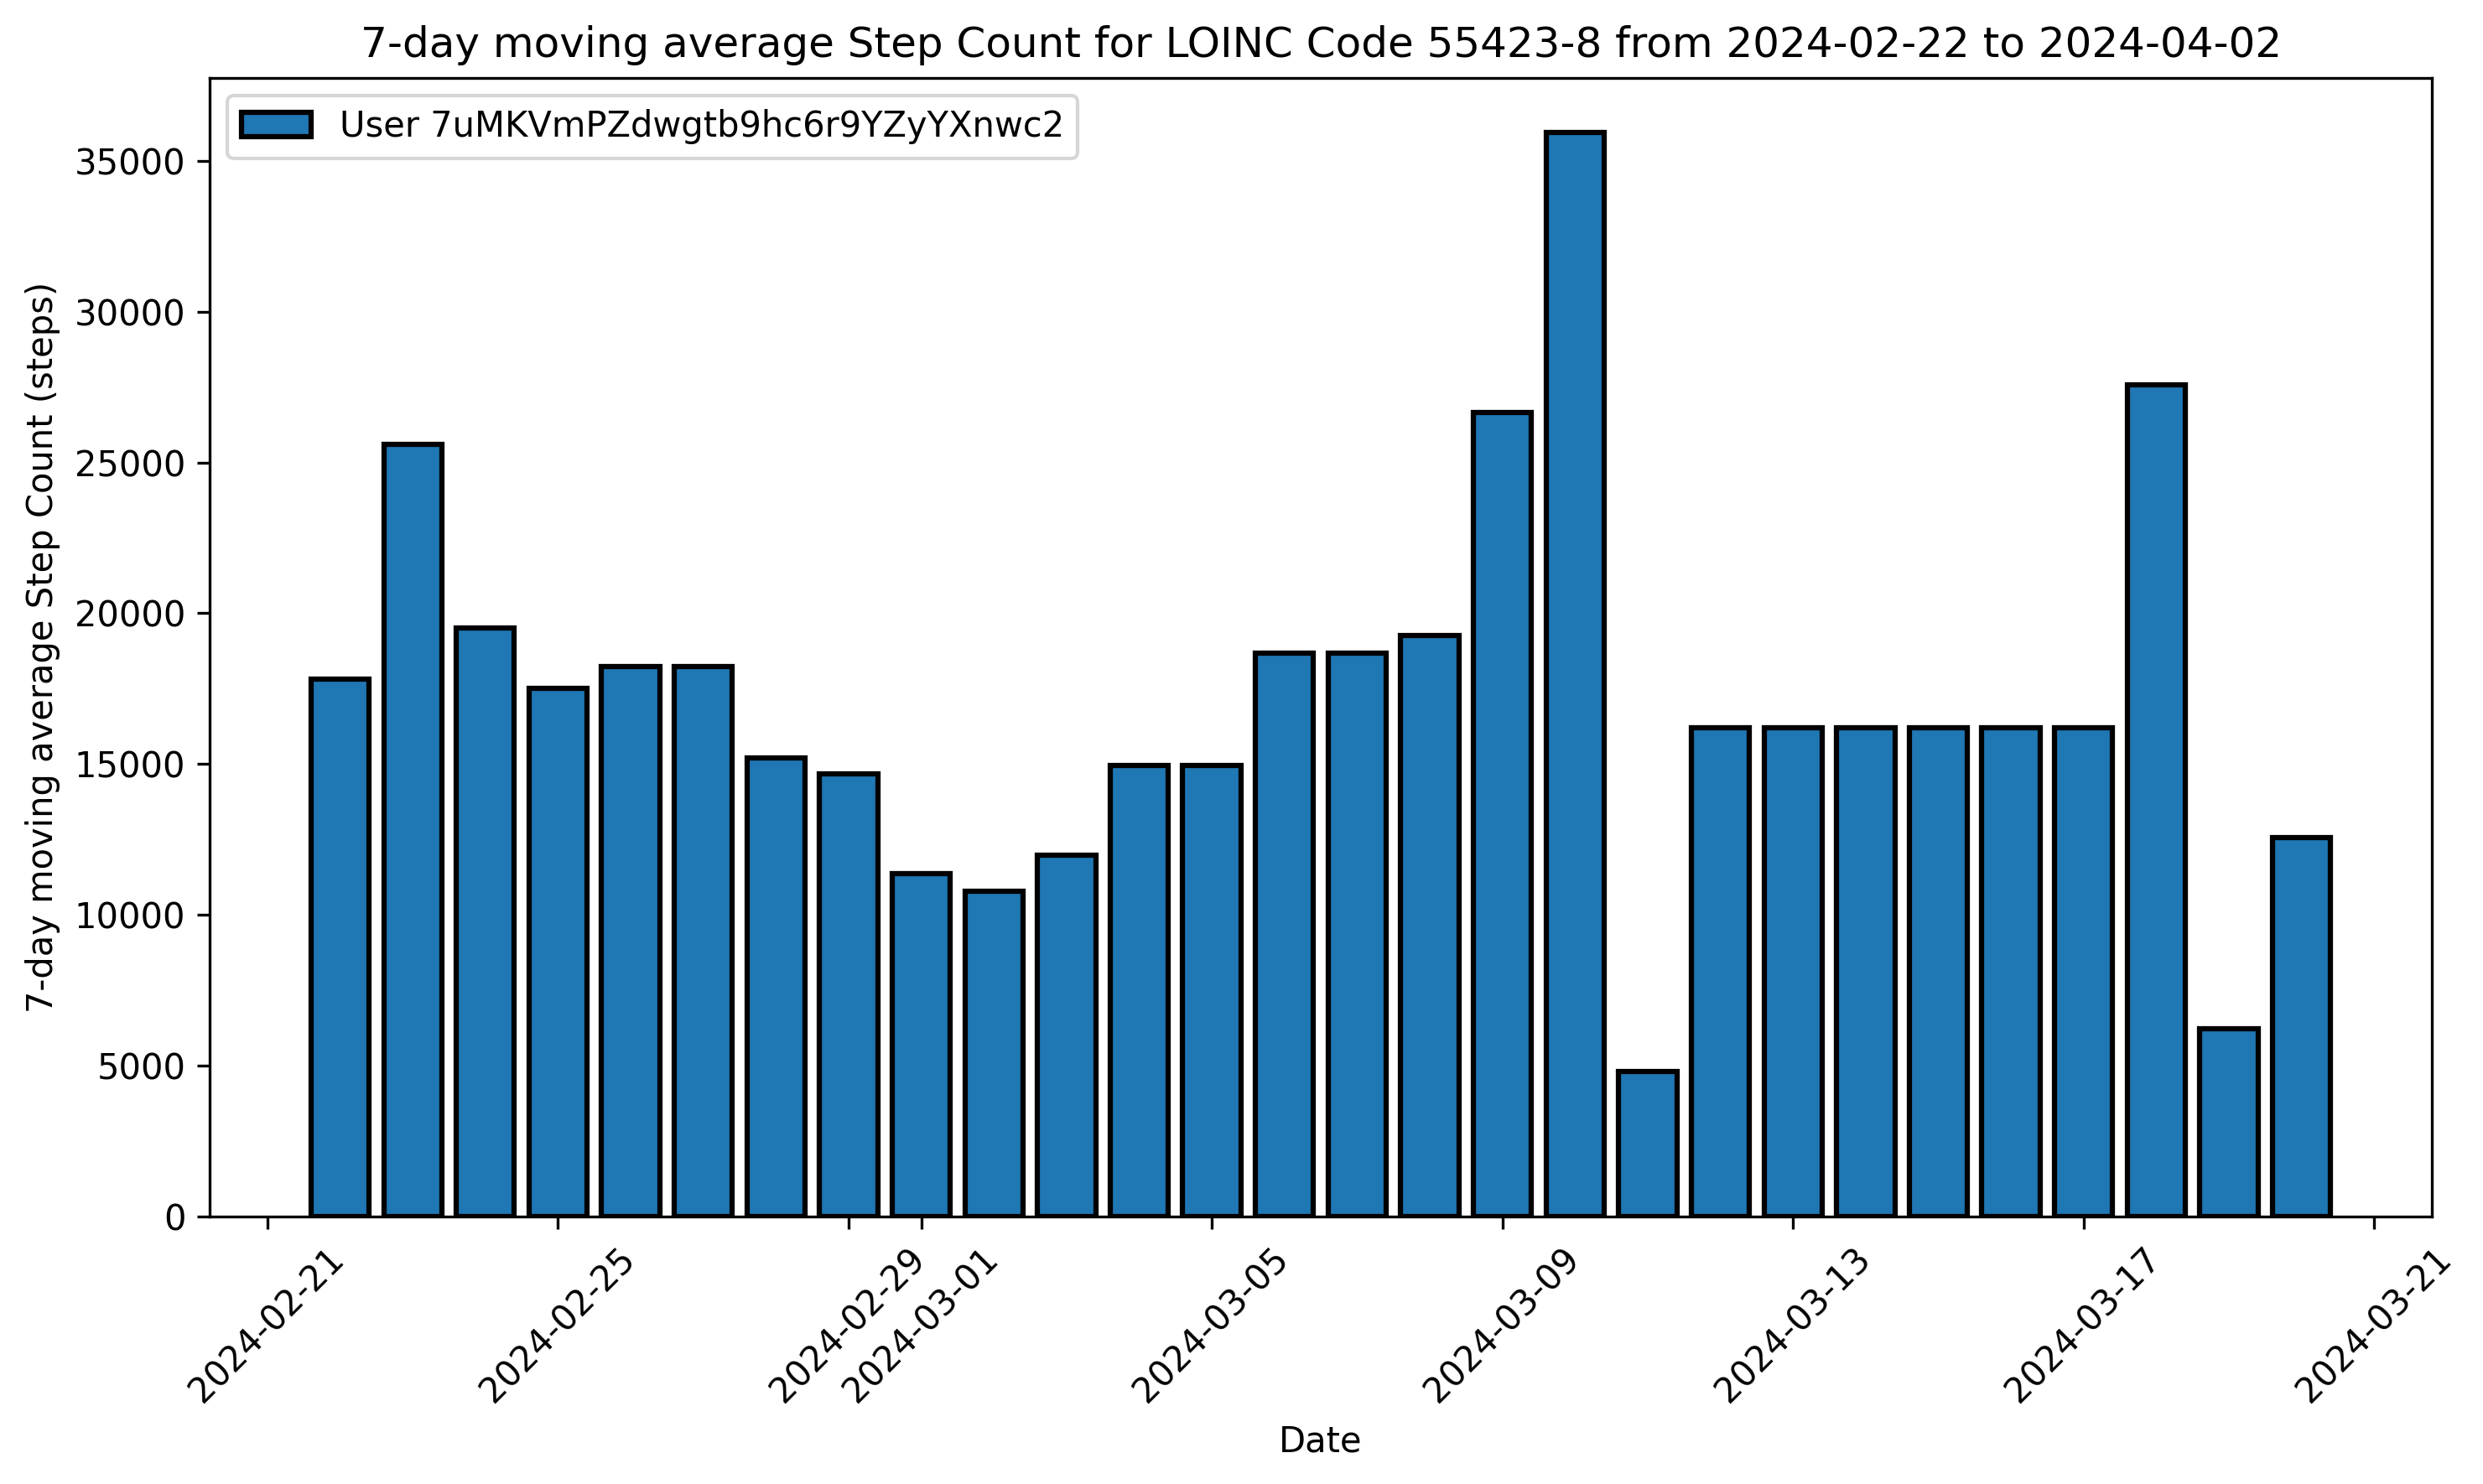

,EffectiveDateTime,UserId,LoincCode,QuantityValue,AppleHealthKitCode,QuantityUnit,QuantityName,Display,MovingAverage
0,2024-04-01,3EUoHxIuYkWMKcnLfK38nTGOqHn1,55423-8,315.0,HKQuantityTypeIdentifierStepCount,steps,7-day moving average Step Count,Number of steps in unspecified time Pedometer,315.0
1,2024-04-02,3EUoHxIuYkWMKcnLfK38nTGOqHn1,55423-8,7221.0,HKQuantityTypeIdentifierStepCount,steps,7-day moving average Step Count,Number of steps in unspecified time Pedometer,7221.0
0,2024-04-19,4HGAZNubNpXoqnEd6HwbJFq51Ck1,55423-8,19367.0,HKQuantityTypeIdentifierStepCount,steps,7-day moving average Step Count,Number of steps in unspecified time Pedometer,19367.0
1,2024-04-20,4HGAZNubNpXoqnEd6HwbJFq51Ck1,55423-8,19367.0,HKQuantityTypeIdentifierStepCount,steps,7-day moving average Step Count,Number of steps in unspecified time Pedometer,19367.0
2,2024-04-21,4HGAZNubNpXoqnEd6HwbJFq51Ck1,55423-8,19367.0,HKQuantityTypeIdentifierStepCount,steps,7-day moving average Step Count,Number of steps in unspecified time Pedometer,19367.0


In [59]:
activity_index_fhir_dataframe = calculate_activity_index(processed_fhir_dataframe)

selected_users = ["XrftRMc358NndzcRWEQ7P2MxvabZ"]
# selected_users = ["7uMKVmPZdwgtb9hc6r9YZyYXnwc2"]
explorer = visualizer_factory(activity_index_fhir_dataframe)

explorer.set_user_ids(selected_users)
explorer.set_date_range(selected_start_date, selected_end_date)

figs = explorer.create_static_plot(activity_index_fhir_dataframe)
activity_index_fhir_dataframe.df.head()

### ECG Recording Example

In [ ]:
# selected_users = ["k3BnzOGAO0fIaxkDVXTZKlj3LAu2", "3EUoHxIuYkWMKcnLfK38nTGOqHn1"]

# selected_start_date = "2023-03-13"
# selected_end_date = "2023-03-13"

# visualizer = visualizer_factory(processed_fhir_dataframe)
# visualizer.set_user_ids(selected_users)
# visualizer.set_date_range(selected_start_date, selected_end_date)
# figs = visualizer.plot_ecg_subplots(processed_fhir_dataframe) 

## Export data

In [ ]:
selected_users = ["sEmijWpn0vXe1cj60GO5kkjkrdT4"]

exporter = DataExporter(processed_fhir_dataframe)
exporter.set_user_ids(selected_users)
exporter.set_date_range(selected_start_date, selected_end_date)
exporter.set_date_range(selected_start_date, selected_start_date)
# exporter.create_and_save_plot("data_plot") 